In [1]:
import scipy.io
import os.path as op
from mne.io import read_epochs_eeglab
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

In [8]:
pipeline='NEARICA'
ages=['9m','12m','adult']

c_cluster_chans=['E16', 'E20', 'E21', 'E22','E41', 'E49', 'E50', 'E51']
p_cluster_chans=['E26', 'E27','E28', 'E31', 'E40','E42', 'E45', 'E46']

Extracting parameters from /home/bonaiuto/dev_beta_umd/data/9m/derivatives/NEARICA/sub-010/processed_data/sub-010_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_14057/1642127165.py:14: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  EEG=read_epochs_eeglab(subject_data_fname)


9m C beta: 13.4-15.4 Hz
9m P beta: 21.400000000000002-34.8 Hz
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/12m/derivatives/NEARICA/sub-001/processed_data/sub-001_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Ready.
12m C beta: 13.9-17.1 Hz
12m P beta: 20.8-37.400000000000006 Hz
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/adult/derivatives/NEARICA/sub-001/processed_data/sub-001_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_14057/1642127165.py:14: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  EEG=read_epochs_eeglab(subject_data_fname)


adult C beta: 18.299999999999997-24.700000000000003 Hz
adult P beta: 30.500000000000007-32.9 Hz


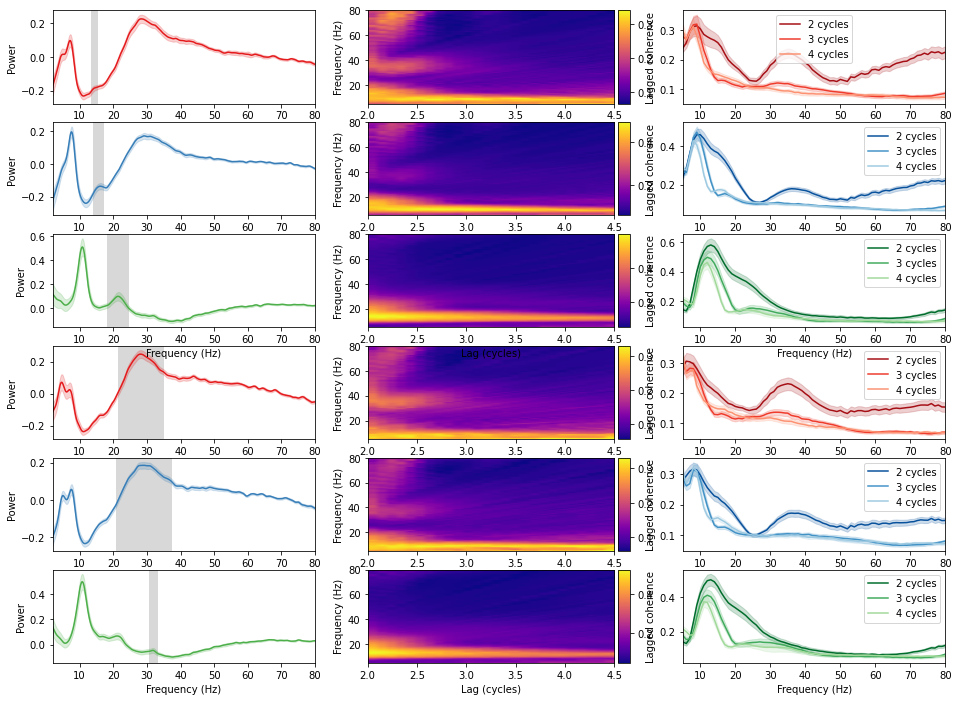

In [22]:
plags=[2,3,4]
    
fig=plt.figure(figsize=(16,12), facecolor='w')
gs = fig.add_gridspec(len(ages)*2,3)

age_colors=np.array([[228,26,28],[55,126,184],[77,175,74]])/255.0
lc_colors=np.array([[[165,15,21],[239,59,44],[252,146,114]],[[8,81,156],[66,146,198],[158,202,225]],[[0,109,44],[65,171,93],[161,217,155]]])/255.0

for age_idx, age in enumerate(ages):
    subjects=pd.read_csv(op.join('/home/bonaiuto/dev_beta_umd/data',age,'data/participants.tsv'), sep='\t')
    subj_id=subjects['participant_id'][0]
    subject_data_fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives', pipeline, 
                               subj_id, 'processed_data', '{}_task-tool_obs_exe_eeg_processed_data.set'.format(subj_id))
    EEG=read_epochs_eeglab(subject_data_fname)


    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_C_fois.mat')
    f = scipy.io.loadmat(fname)
    all_fois=f['fois'][0]
    ranges=np.zeros((len(all_fois),2))
    for f_idx,foi in enumerate(all_fois):
        ranges[f_idx,:]=foi[0][0]
    ranges=ranges[ranges[:, 0].argsort()]
    c_beta_idx=np.where(ranges[:,1]<=30)[0][-1]
    c_beta_range=ranges[c_beta_idx,:]    
    
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_P_fois.mat')
    f = scipy.io.loadmat(fname)
    all_fois=f['fois'][0]
    ranges=np.zeros((len(all_fois),2))
    for f_idx,foi in enumerate(all_fois):
        ranges[f_idx,:]=foi[0][0]
    ranges=ranges[ranges[:, 0].argsort()]
    p_beta_idx=np.where(ranges[:,1]<=30)[0][-1]+1
    p_beta_range=ranges[p_beta_idx,:]    
    
    print('{} C beta: {}-{} Hz'.format(age,c_beta_range[0],c_beta_range[1]))
    print('{} P beta: {}-{} Hz'.format(age,p_beta_range[0],p_beta_range[1]))

    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_psd.mat')
    f = scipy.io.loadmat(fname)
    frex=f['frex'][:,0]
    periodic=f['periodic']
    freq_idx=np.where((frex<=80))[0]
    frex=frex[freq_idx]
    periodic=periodic[:,:,freq_idx]
    
    c_chan_idx=[]
    p_chan_idx=[]
    for chan in c_cluster_chans:
        c_chan_idx.append(EEG.info['ch_names'].index(chan))
    for chan in p_cluster_chans:
        p_chan_idx.append(EEG.info['ch_names'].index(chan))
        
    ax = fig.add_subplot(gs[age_idx, 0])    
    mean_resids=np.nanmean(np.nanmean(periodic[:,c_chan_idx,:],axis=1),axis=0)
    se_resids=np.nanstd(np.nanmean(periodic[:,c_chan_idx,:],axis=1),axis=0)/np.sqrt(periodic.shape[0])
    ax.plot(frex,mean_resids, color=age_colors[age_idx,:])
    ax.fill_between(frex,mean_resids-se_resids,mean_resids+se_resids, alpha=.2, color=age_colors[age_idx,:])
    yl=ax.get_ylim()
    mask = np.ones((100,10))
    graynorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=1.1)
    ax.imshow(mask,cmap="gray_r", origin="lower", norm=graynorm, 
              extent=[c_beta_range[0], c_beta_range[1], yl[0], yl[1]], 
              aspect="auto", interpolation="none",alpha=0.3, rasterized=True)
    ax.set_xlim(frex[[0,-1]])
    ax.set_ylim(yl)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    
    ax = fig.add_subplot(gs[len(ages)+age_idx, 0])    
    mean_resids=np.nanmean(np.nanmean(periodic[:,p_chan_idx,:],axis=1),axis=0)
    se_resids=np.nanstd(np.nanmean(periodic[:,p_chan_idx,:],axis=1),axis=0)/np.sqrt(periodic.shape[0])
    ax.plot(frex,mean_resids, color=age_colors[age_idx,:])
    ax.fill_between(frex,mean_resids-se_resids,mean_resids+se_resids, alpha=.2, color=age_colors[age_idx,:])
    yl=ax.get_ylim()
    mask = np.ones((100,10))
    graynorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=1.1)
    ax.imshow(mask,cmap="gray_r", origin="lower", norm=graynorm, 
              extent=[p_beta_range[0], p_beta_range[1], yl[0], yl[1]], 
              aspect="auto", interpolation="none",alpha=0.3, rasterized=True)
    ax.set_xlim(frex[[0,-1]])
    ax.set_ylim(yl)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    
    # Load lagged coherence
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_lagged_coherence.mat')
    f = scipy.io.loadmat(fname)
    foi=f['foi'][0,:]
    lags=f['lags'][0,:]
    lagged_coh=f['lagged_coh']

    freq_idx=np.where((foi>=5) & (foi<=80))[0]
    foi=foi[freq_idx]
    lag_idx=np.where((lags<=4.5))[0]
    lags=lags[lag_idx]
    lagged_coh=lagged_coh[:,:,freq_idx,:]
    lagged_coh=lagged_coh[:,:,:,lag_idx]

    for s in range(lagged_coh.shape[0]):
        subj_lagged_coh=lagged_coh[s,:,:,:]
        lagged_coh[s,:,:,:]=subj_lagged_coh/np.max(subj_lagged_coh[:])

    
    ax = fig.add_subplot(gs[age_idx, 1])
    m_lagged_coh=np.nanmean(lagged_coh[:,c_chan_idx,:,:],axis=1)
    i1=ax.imshow(np.mean(m_lagged_coh,axis=0), aspect='auto', cmap='plasma', 
                  extent=[lags[0], lags[-1], foi[0], foi[-1]], 
                  origin='lower')
    ax.set_xlabel('Lag (cycles)')
    ax.set_ylabel('Frequency (Hz)')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(i1, cax=cax)
    
    ax = fig.add_subplot(gs[len(ages)+age_idx, 1])
    m_lagged_coh=np.nanmean(lagged_coh[:,p_chan_idx,:,:],axis=1)
    i1=ax.imshow(np.mean(m_lagged_coh,axis=0), aspect='auto', cmap='plasma', 
                  extent=[lags[0], lags[-1], foi[0], foi[-1]], 
                  origin='lower')
    ax.set_xlabel('Lag (cycles)')
    ax.set_ylabel('Frequency (Hz)')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(i1, cax=cax)
        
    
    ax = fig.add_subplot(gs[age_idx, 2])        
    m_lagged_coh=np.nanmean(lagged_coh[:,c_chan_idx,:,:],axis=1)
    for pidx, plag in enumerate(plags):
        c=lc_colors[age_idx,pidx,:]
        lag_idx=np.where((lags>=plag) & (lags<=plag+.5))[0]
        m_lc=np.nanmean(np.nanmean(m_lagged_coh[:,:,lag_idx],axis=2),axis=0)
        se_lc=np.nanstd(np.nanmean(m_lagged_coh[:,:,lag_idx],axis=2),axis=0)/np.sqrt(m_lagged_coh.shape[0])
        ax.plot(foi,m_lc,label='{} cycles'.format(plag),color=c)
        ax.fill_between(foi,m_lc-se_lc,m_lc+se_lc,color=c,alpha=.2)        
    ax.set_xlim(foi[[0,-1]])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Lagged coherence')
    ax.legend()
    
    ax = fig.add_subplot(gs[len(ages)+age_idx, 2])        
    m_lagged_coh=np.nanmean(lagged_coh[:,p_chan_idx,:,:],axis=1)
    for pidx, plag in enumerate(plags):
        c=lc_colors[age_idx,pidx,:]
        lag_idx=np.where((lags>=plag) & (lags<=plag+.5))[0]
        m_lc=np.nanmean(np.nanmean(m_lagged_coh[:,:,lag_idx],axis=2),axis=0)
        se_lc=np.nanstd(np.nanmean(m_lagged_coh[:,:,lag_idx],axis=2),axis=0)/np.sqrt(m_lagged_coh.shape[0])
        ax.plot(foi,m_lc,label='{} cycles'.format(plag),color=c)
        ax.fill_between(foi,m_lc-se_lc,m_lc+se_lc,color=c,alpha=.2)        
    ax.set_xlim(foi[[0,-1]])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Lagged coherence')
    ax.legend()
fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure1.svg')
fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure1.png')

Extracting parameters from /home/bonaiuto/dev_beta_umd/data/9m/derivatives/NEARICA/sub-010/processed_data/sub-010_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_14057/2465767.py:24: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  EEG=read_epochs_eeglab(subject_data_fname)


Extracting parameters from /home/bonaiuto/dev_beta_umd/data/12m/derivatives/NEARICA/sub-001/processed_data/sub-001_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/adult/derivatives/NEARICA/sub-001/processed_data/sub-001_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_14057/2465767.py:24: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  EEG=read_epochs_eeglab(subject_data_fname)


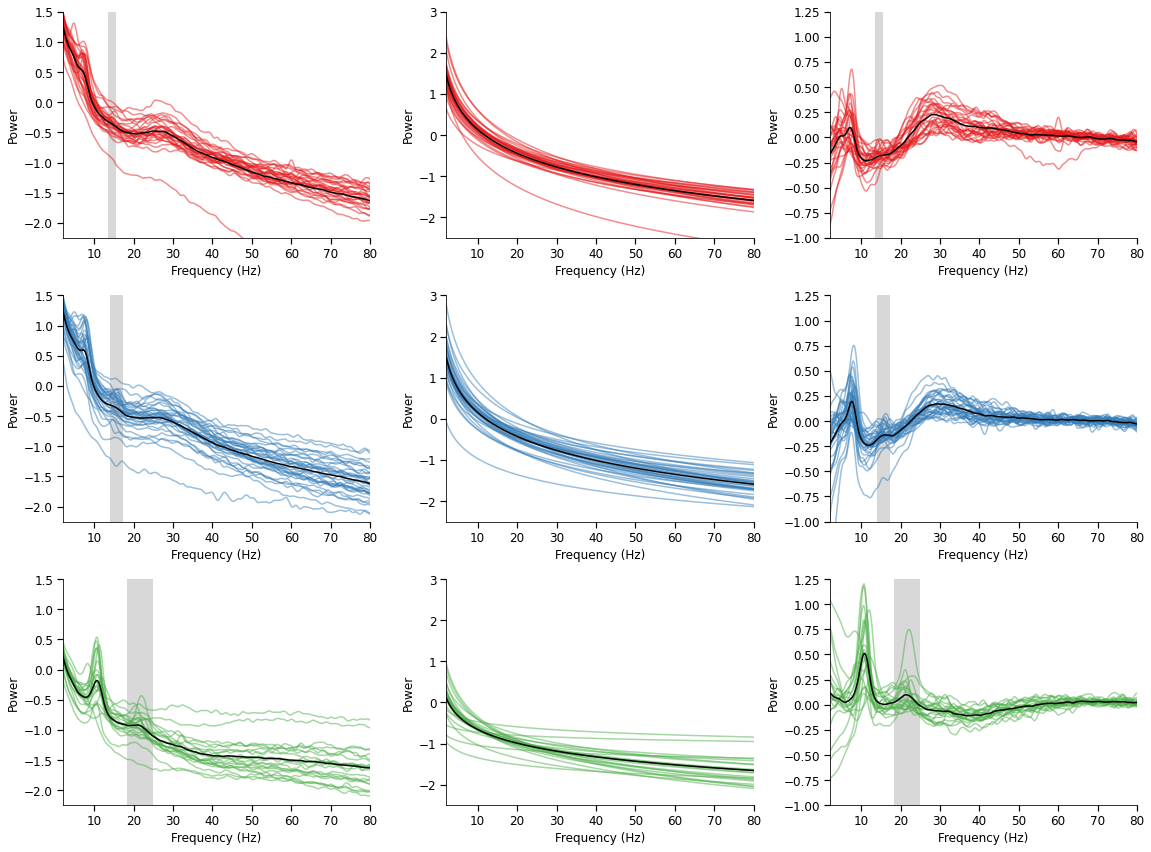

In [39]:
plt.rcParams.update({
    'font.size': 12,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})
fig=plt.figure(figsize=(16,12), facecolor='w')
gs = fig.add_gridspec(len(ages),3)

age_colors=np.array([[228,26,28],[55,126,184],[77,175,74]])/255.0
for age_idx, age in enumerate(ages):
    
    subjects=pd.read_csv(op.join('/home/bonaiuto/dev_beta_umd/data',age,'data/participants.tsv'), sep='\t')
    subj_id=subjects['participant_id'][0]
    subject_data_fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives', pipeline, 
                               subj_id, 'processed_data', '{}_task-tool_obs_exe_eeg_processed_data.set'.format(subj_id))
    EEG=read_epochs_eeglab(subject_data_fname)


    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_C_fois.mat')
    f = scipy.io.loadmat(fname)
    all_fois=f['fois'][0]
    ranges=np.zeros((len(all_fois),2))
    for f_idx,foi in enumerate(all_fois):
        ranges[f_idx,:]=foi[0][0]
    ranges=ranges[ranges[:, 0].argsort()]
    beta1_idx=np.where(ranges[:,1]<=30)[0][-1]
    beta1_range=ranges[beta1_idx,:]    
        
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_psd.mat')
    f = scipy.io.loadmat(fname)
    frex=f['frex'][:,0]
    spectra=f['spectra']
    aperiodic=f['aperiodic']
    periodic=f['periodic']
    freq_idx=np.where((frex<=80))[0]
    frex=frex[freq_idx]
    spectra=spectra[:,:,freq_idx]
    periodic=periodic[:,:,freq_idx]
    aperiodic=aperiodic[:,:,freq_idx]
    
    chan_idx=[]
    for chan in c_cluster_chans:
        chan_idx.append(EEG.info['ch_names'].index(chan))

    ax = fig.add_subplot(gs[age_idx, 0])
    for s in range(spectra.shape[0]):
        ax.plot(frex,np.nanmean(spectra[s,chan_idx,:],axis=0),color=age_colors[age_idx,:],alpha=.5)        
    ax.plot(frex,np.nanmean(np.nanmean(spectra[:,chan_idx,:],axis=1),axis=0),color='k')        
    yl=[-2.25,1.5]
    mask = np.ones((100,10))
    graynorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=1.1)
    ax.imshow(mask,cmap="gray_r", origin="lower", norm=graynorm, 
              extent=[beta1_range[0], beta1_range[1], yl[0], yl[1]], 
              aspect="auto", interpolation="none",alpha=0.3, rasterized=True)
    ax.set_xlim(frex[[0,-1]])
    ax.set_ylim(yl)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
        
    ax = fig.add_subplot(gs[age_idx, 1])
    for s in range(aperiodic.shape[0]):
        ax.plot(frex,np.nanmean(aperiodic[s,chan_idx,:],axis=0),color=age_colors[age_idx,:],alpha=.5)
    ax.plot(frex,np.nanmean(np.nanmean(aperiodic[:,chan_idx,:],axis=1),axis=0),color='k')
    ax.set_xlim(frex[[0,-1]])
    ax.set_ylim([-2.5,3])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    
    ax = fig.add_subplot(gs[age_idx, 2])
    for s in range(periodic.shape[0]):
        ax.plot(frex,np.nanmean(periodic[s,chan_idx,:],axis=0),color=age_colors[age_idx,:],alpha=.5)    
    ax.plot(frex,np.nanmean(np.nanmean(periodic[:,chan_idx,:],axis=1),axis=0),color='k')    
    yl=[-1.0,1.25]
    ax.imshow(mask,cmap="gray_r", origin="lower", norm=graynorm, 
              extent=[beta1_range[0], beta1_range[1], yl[0], yl[1]], 
              aspect="auto", interpolation="none",alpha=0.3, rasterized=True)
    ax.set_xlim(frex[[0,-1]])
    ax.set_ylim(yl)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')

plt.tight_layout()
    
fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure_s1.svg')
fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure_s1.png')

Extracting parameters from /home/bonaiuto/dev_beta_umd/data/9m/derivatives/NEARICA/sub-010/processed_data/sub-010_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_14057/2353797455.py:25: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  EEG=read_epochs_eeglab(subject_data_fname)


Extracting parameters from /home/bonaiuto/dev_beta_umd/data/12m/derivatives/NEARICA/sub-001/processed_data/sub-001_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/adult/derivatives/NEARICA/sub-001/processed_data/sub-001_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_14057/2353797455.py:25: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  EEG=read_epochs_eeglab(subject_data_fname)


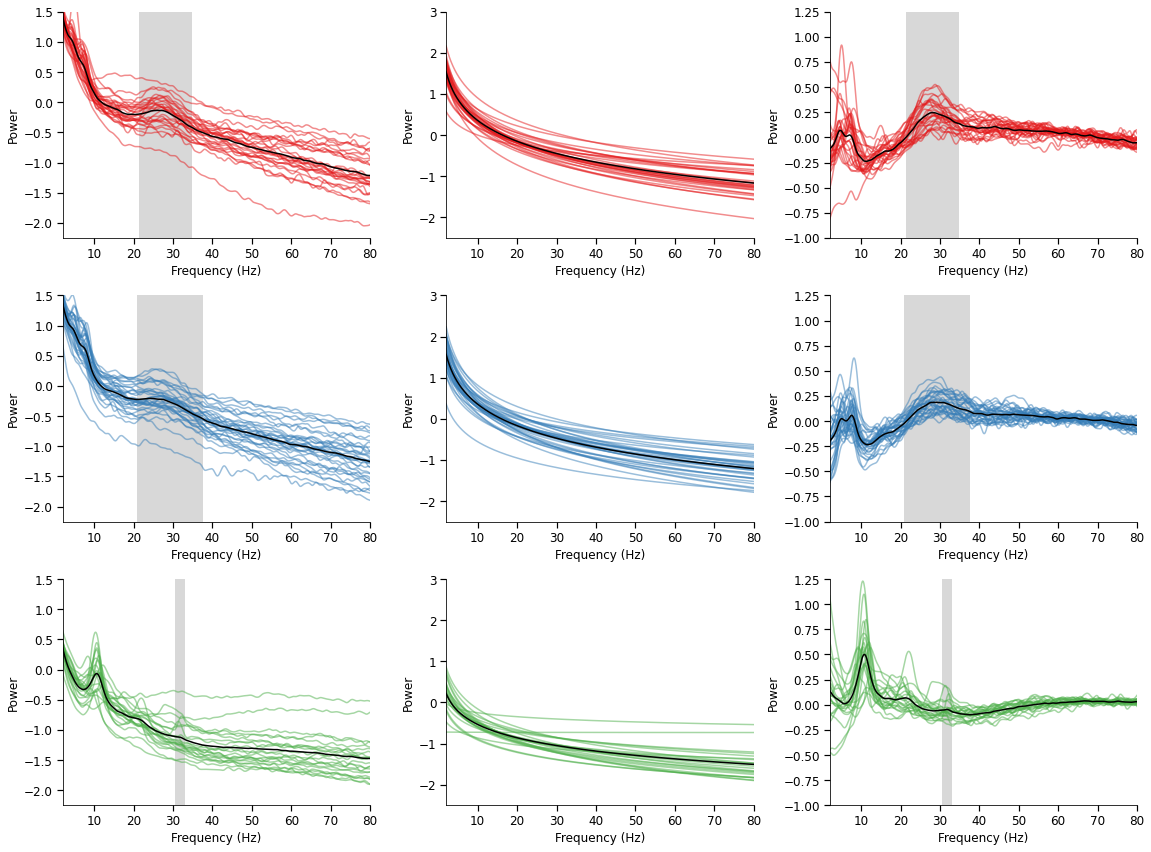

In [40]:
plt.rcParams.update({
    'font.size': 12,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

fig=plt.figure(figsize=(16,12), facecolor='w')
gs = fig.add_gridspec(len(ages),3)

age_colors=np.array([[228,26,28],[55,126,184],[77,175,74]])/255.0
for age_idx, age in enumerate(ages):
    
    subjects=pd.read_csv(op.join('/home/bonaiuto/dev_beta_umd/data',age,'data/participants.tsv'), sep='\t')
    subj_id=subjects['participant_id'][0]
    subject_data_fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives', pipeline, 
                               subj_id, 'processed_data', '{}_task-tool_obs_exe_eeg_processed_data.set'.format(subj_id))
    EEG=read_epochs_eeglab(subject_data_fname)


    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_P_fois.mat')
    f = scipy.io.loadmat(fname)
    all_fois=f['fois'][0]
    ranges=np.zeros((len(all_fois),2))
    for f_idx,foi in enumerate(all_fois):
        ranges[f_idx,:]=foi[0][0]
    ranges=ranges[ranges[:, 0].argsort()]
    beta1_idx=np.where(ranges[:,1]<=30)[0][-1]
    beta2_idx=beta1_idx+1
    beta2_range=ranges[beta2_idx,:]
        
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_psd.mat')
    f = scipy.io.loadmat(fname)
    frex=f['frex'][:,0]
    spectra=f['spectra']
    aperiodic=f['aperiodic']
    periodic=f['periodic']
    freq_idx=np.where((frex<=80))[0]
    frex=frex[freq_idx]
    spectra=spectra[:,:,freq_idx]
    periodic=periodic[:,:,freq_idx]
    aperiodic=aperiodic[:,:,freq_idx]
    
    chan_idx=[]
    for chan in p_cluster_chans:
        chan_idx.append(EEG.info['ch_names'].index(chan))

    ax = fig.add_subplot(gs[age_idx, 0])
    for s in range(spectra.shape[0]):
        ax.plot(frex,np.nanmean(spectra[s,chan_idx,:],axis=0),color=age_colors[age_idx,:],alpha=.5)        
    ax.plot(frex,np.nanmean(np.nanmean(spectra[:,chan_idx,:],axis=1),axis=0),color='k')        
    yl=[-2.25,1.5]
    mask = np.ones((100,10))
    graynorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=1.1)
    ax.imshow(mask,cmap="gray_r", origin="lower", norm=graynorm, 
              extent=[beta2_range[0], beta2_range[1], yl[0], yl[1]], 
              aspect="auto", interpolation="none",alpha=0.3, rasterized=True)
    ax.set_xlim(frex[[0,-1]])
    ax.set_ylim(yl)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
        
    ax = fig.add_subplot(gs[age_idx, 1])
    for s in range(aperiodic.shape[0]):
        ax.plot(frex,np.nanmean(aperiodic[s,chan_idx,:],axis=0),color=age_colors[age_idx,:],alpha=.5)
    ax.plot(frex,np.nanmean(np.nanmean(aperiodic[:,chan_idx,:],axis=1),axis=0),color='k')
    ax.set_xlim(frex[[0,-1]])
    ax.set_ylim([-2.5,3])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    
    ax = fig.add_subplot(gs[age_idx, 2])
    for s in range(periodic.shape[0]):
        ax.plot(frex,np.nanmean(periodic[s,chan_idx,:],axis=0),color=age_colors[age_idx,:],alpha=.5)    
    ax.plot(frex,np.nanmean(np.nanmean(periodic[:,chan_idx,:],axis=1),axis=0),color='k')    
    yl=[-1.0,1.25]
    ax.imshow(mask,cmap="gray_r", origin="lower", norm=graynorm, 
              extent=[beta2_range[0], beta2_range[1], yl[0], yl[1]], 
              aspect="auto", interpolation="none",alpha=0.3, rasterized=True)
    ax.set_xlim(frex[[0,-1]])
    ax.set_ylim(yl)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    
plt.tight_layout()

fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure_s2.svg')
fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure_s2.png')